In [41]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import os
import pandas as pd

In [29]:
epoch_num = 5
sequence_length = 6  # Number of time steps to consider

In [30]:
# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data = pd.read_csv(data_path, usecols=ucols)
data.reset_index(drop=True, inplace=True)
data.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [31]:
ohlc_data = data

# Normalize the data
scaler = MinMaxScaler()
ohlc_scaled = scaler.fit_transform(ohlc_data)

# Convert OHLC data into sequences (LSTM requires 3D input)
X = []
for i in range(len(ohlc_scaled) - sequence_length):
    X.append(ohlc_scaled[i:i+sequence_length])

X = np.array(X)  # Shape: (num_samples, sequence_length, num_features)

# Define LSTM encoder
def create_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    x = Dense(32, activation='relu')(x)
    return Model(inputs, x)

# Create encoder model
encoder = create_encoder((sequence_length, 4))

# Extract feature embeddings
features = encoder.predict(X)

1936/1936 [==============================] - 14s 6ms/step


In [32]:
# Apply K-Means clustering
num_clusters = 3  # Buy (2), Sell (1), Hold (0)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)  # Assign cluster labels

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
clusters[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

# Apply Time-Series Aware K-Means with DTW metric
dtw_kmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", random_state=42)
clusters = dtw_kmeans.fit_predict(features.reshape(-1, 1, features.shape[1]))  # Reshape for time-series input


In [ ]:
clusters[:100]

In [9]:
# Convert cluster labels to categorical for classification training
clusters_one_hot = to_categorical(clusters, num_classes=num_clusters)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, clusters_one_hot, test_size=0.2, random_state=42)

# Define classification model
classifier_output = Dense(num_clusters, activation="softmax")(encoder.output)
final_model = Model(encoder.input, classifier_output)

# Compile and train classifier
final_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
final_model.fit(X_train, y_train, epochs=epoch_num, batch_size=5, validation_data=(X_test, y_test))

# Evaluate model on test data
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



1936/1936 [==============================] - 15s 6ms/step


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/5
9909/9909 [==============================] - 119s 11ms/step - loss: 0.1033 - accuracy: 0.9582 - val_loss: 0.0298 - val_accuracy: 0.9915
Epoch 2/5
9909/9909 [==============================] - 110s 11ms/step - loss: 0.0623 - accuracy: 0.9746 - val_loss: 0.0434 - val_accuracy: 0.9802
Epoch 3/5
9909/9909 [==============================] - 111s 11ms/step - loss: 0.0510 - accuracy: 0.9794 - val_loss: 0.0838 - val_accuracy: 0.9621
Epoch 4/5
9909/9909 [==============================] - 112s 11ms/step - loss: 0.0471 - accuracy: 0.9808 - val_loss: 0.0374 - val_accuracy: 0.9817
Epoch 5/5
388/388 [==============================] - 3s 8ms/step - loss: 0.0355 - accuracy: 0.9835
Test Accuracy: 98.35%


In [12]:
final_model.save("trading_model.h5")
loaded_model = load_model("trading_model.h5")


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt  # pip install MetaTrader5
import pandas as pd  # pip install pandas
from datetime import datetime, timedelta
import os

# start the platform with initialize()
mt.initialize()

# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 165905041
password = 'iIeElL0176_'
server = 'XMGlobal-MT5 2'

mt.login(login, password, server)



True

In [15]:
# Define symbol and timeframe
symbol = "EURUSD"
timeframe = mt.TIMEFRAME_H1

# Get data for the last 48 hours
end_time = datetime.now()
start_time = end_time - timedelta(hours=1000)

# Retrieve OHLC data
ohlc_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, start_time, end_time))

# Convert time column to datetime format
ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')


ohlc_data.rename(columns={'open':'Open', 'high':'High', 
                        'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
columns_to_drop = ['time', 'spread', 'real_volume', 'Volume']
ohlc_data.drop(columns=[col for col in columns_to_drop if col in ohlc_data.columns], inplace=True)



In [16]:
ohlc_data

,Open,High,Low,Close
0,1.03722,1.03753,1.03160,1.03322
1,1.03319,1.03527,1.03243,1.03493
2,1.03493,1.03818,1.03371,1.03737
3,1.03737,1.03947,1.03495,1.03903
4,1.03904,1.04266,1.03899,1.04253
...,...,...,...,...
708,1.07879,1.07913,1.07826,1.07834
709,1.07834,1.07944,1.07771,1.07926
710,1.07925,1.07962,1.07893,1.07943
711,1.07943,1.07954,1.07828,1.07850


In [20]:
df = new_data = ohlc_data

In [21]:
new_data = new_data[['Open', 'High', 'Low', 'Close']].values  # Extract OHLC values

# Normalize using MinMaxScaler (Make sure it's the same scaler used during training)
scaler = MinMaxScaler()
ohlc_data_scaled = scaler.fit_transform(ohlc_data)  # If you saved the original scaler, load it instead.

# Create sequences using a sliding window
X_test = []
for i in range(len(ohlc_data_scaled) - sequence_length):
    X_test.append(ohlc_data_scaled[i : i + sequence_length])

X_test = np.array(X_test)  # Now it has shape (num_samples, sequence_length, features)

# Load trained model
model = loaded_model

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Map predictions to labels
labels = {0: "Hold", 1: "Sell", 2: "Buy"}
predicted_labels = [labels[p] for p in predicted_classes]

# Align predictions with the original DataFrame
df = df.iloc[sequence_length:]  # Offset by sequence_length to match prediction output
df["Prediction"] = predicted_labels  # Add predicted actions to DataFrame

# Save the results
df.to_csv("predicted_results.csv", index=False)

# Print first 10 rows with predictions
print(df.head(10))


23/23 [==============================] - 1s 6ms/step
       Open     High      Low    Close Prediction
6   1.03885  1.03925  1.03837  1.03902       Hold
7   1.03902  1.03965  1.03871  1.03908       Hold
8   1.03909  1.03955  1.03798  1.03811       Hold
9   1.03809  1.03854  1.03789  1.03831       Hold
10  1.03831  1.03913  1.03815  1.03913       Hold
11  1.03913  1.03996  1.03872  1.03886       Hold
12  1.03886  1.04011  1.03863  1.03988       Hold
13  1.03988  1.04067  1.03957  1.04031       Hold
14  1.04031  1.04211  1.04024  1.04181       Hold
15  1.04183  1.04345  1.04179  1.04339       Hold


C:\Users\Teacher\AppData\Local\Temp\ipykernel_17440\74426318.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Prediction"] = predicted_labels  # Add predicted actions to DataFrame


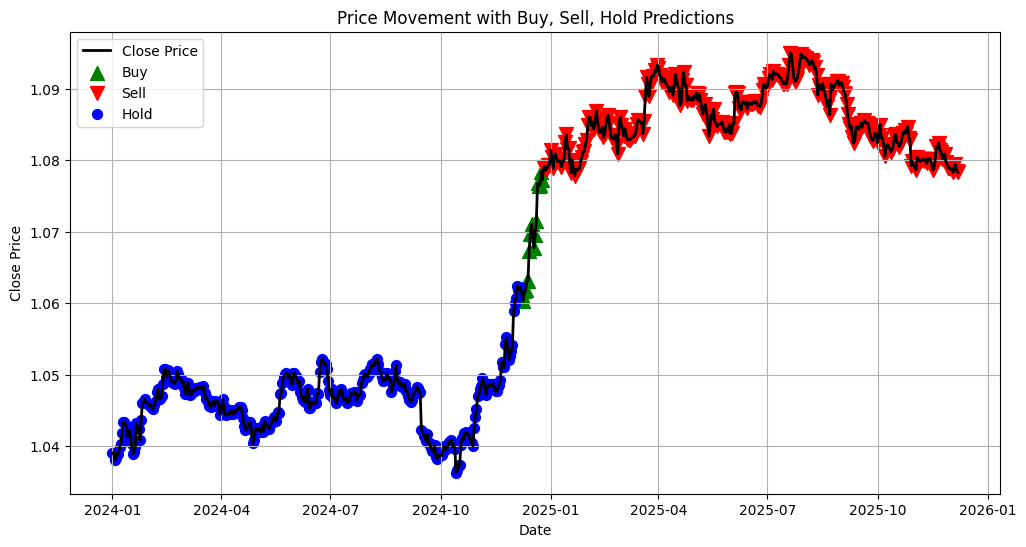

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load predicted dataset
df = pd.read_csv("predicted_results.csv")

# Create a synthetic date index (since no date column is present)
df["Date"] = pd.date_range(start="2024-01-01", periods=len(df), freq="D")  # Adjust as needed
df.set_index("Date", inplace=True)  # Set Date as index

# Extract Buy, Sell, Hold markers
buy_signals = df[df["Prediction"] == "Buy"]
sell_signals = df[df["Prediction"] == "Sell"]
hold_signals = df[df["Prediction"] == "Hold"]

# Plot Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Close Price", color="black", linewidth=2)

# Add Buy/Sell/Hold markers
plt.scatter(buy_signals.index, buy_signals["Close"], color="green", label="Buy", marker="^", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], color="red", label="Sell", marker="v", s=100)
plt.scatter(hold_signals.index, hold_signals["Close"], color="blue", label="Hold", marker="o", s=50)

# Labels and legend
plt.title("Price Movement with Buy, Sell, Hold Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()

# Show plot
plt.show()
